In [1]:
import sys
sys.path.append('..')

from deepgraph.utils.logging import log
from deepgraph.utils.common import batch_parallel, ConfigMixin, shuffle_in_unison_inplace, pickle_dump
from deepgraph.utils.image import batch_pad_mirror
from deepgraph.constants import *
from deepgraph.conf import rng

from deepgraph.pipeline import Processor, Packet

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 90.0% of memory, cuDNN Version is too old. Update to v5, was 2000.)


In [3]:
from deepgraph.nn.init import *
from deepgraph.node import Node

# Custom loss node
class MaskedLogLoss(Node):
    """
    Compute log scale invariant error for depth prediction
    """
    def __init__(self, graph, name, config={}):
        """
        Constructor
        :param graph: Graph
        :param name: String
        :param config: Dict
        :return: Node
        """
        super(MaskedLogLoss, self).__init__(graph, name, config=config)
        self.is_loss = True

    def setup_defaults(self):
        super(MaskedLogLoss, self).setup_defaults()
        self.conf_default("loss_weight", 1.0)
        self.conf_default("lambda", 0.2)
        self.conf_default("label_index", 1)

    def alloc(self):
            if len(self.inputs) != 2:
                raise AssertionError("This node needs exactly two inputs to calculate loss.")
            self.output_shape = (1,)

    def forward(self):
            # Define our forward function
            if self.conf("label_index") == 1:
                pred = self.inputs[0].expression
                target = self.inputs[1].expression
            else:
                pred = self.inputs[1].expression
                target = self.inputs[0].expression
            
            # Compute a mask which removes invalid values or 0
            null_mask = T.gt(target,0)
            # Compute a mask which removes the max values of a depth image
            max_mask = T.lt(target, T.max(target))
            # Min mask
            min_mask = T.gt(target, T.min(target))
            # Combine masks
            mask = null_mask * max_mask * min_mask
            # Now we compute the log of the input data stream, but neglect invalid values
            log_target = T.switch(mask, T.log(target),0)
            # We also apply the mask to our predictions in order to avoid computation of gradients on invalid pixels
            masked_pred = mask * pred
            # We compute the difference here to construct l_2 norm later in log space, neglecting invalid pixels
            diff = log_target - masked_pred
            # We also have to compute the mean only on valid pixels, so we need the number of valid pixels
            n_valid = mask.sum()
            # Finally compute the scale invariant error 
            self.expression = T.sum(diff**2) / n_valid - ((self.conf("lambda") / (n_valid**2)) * (T.sum(diff)**2))
            
            
            
# Input data transformer
class Transformer(Processor):
    """
    Apply online random augmentation.
    """
    def __init__(self, name, shapes, config, buffer_size=10):
        super(Transformer, self).__init__(name, shapes, config, buffer_size)
        self.mean = None

    def init(self):
        if self.conf("mean_file") is not None:
            self.mean = np.load(self.conf("mean_file"))
        else:
            log("Transformer - No mean file specified.", LOG_LEVEL_WARNING)

    def process(self):
        packet = self.pull()
        # Return if no data is there
        if not packet:
            return False
        # Unpack
        data, label = packet.data
        # Do processing
        log("Transformer - Processing data", LOG_LEVEL_VERBOSE)
        
        h = 240
        w = 320
        
        start = time.time()
        # Mean
        if packet.phase == PHASE_TRAIN or packet.phase == PHASE_VAL:
            data = data.astype(np.float32)
            if self.mean is not None:
                std = self.conf("std_norm")
                for idx in range(data.shape[0]):
                    # Subtract mean
                    data[idx] = data[idx] - self.mean.astype(np.float32)
                    if std is not None:
                        data[idx] =  data[idx] * std
            if self.conf("offset") is not None:
                label -= self.conf("offset")
            if self.conf("pred_std_norm") is not None:
                label *= self.conf("pred_std_norm")

        if packet.phase == PHASE_TRAIN:
             # Do elementwise operations
            data_old = data
            label_old = label
            data = np.zeros((data_old.shape[0], data_old.shape[1], h, w), dtype=np.float32)
            label = np.zeros((label_old.shape[0], h, w), dtype=np.float32)
            for idx in range(data.shape[0]):
                # Rotate
                # We rotate before cropping to be able to get filled corners
                # Maybe even adjust the border after rotating
                deg = np.random.randint(-5,6)
                # Operate on old data. Careful - data is already in float so we need to normalize and rescale afterwards
                # data_old[idx] = 255. * rotate_transformer_rgb_uint8(data_old[idx] * 0.003921568627, deg).astype(np.float32)
                # label_old[idx] = rotate_transformer_scalar_float32(label_old[idx], deg)
                
                # Take care of any empty areas, we crop on a smaller surface depending on the angle
                # TODO Remove this once loss supports masking

                shift = 0 #np.tan((deg/180.) * math.pi)
                # Random crops
                cy = rng.randint(data_old.shape[2] - h - shift, size=1)
                cx = rng.randint(data_old.shape[3] - w - shift, size=1)

                data[idx] = data_old[idx, :, cy:cy+h, cx:cx+w]
                label[idx] = label_old[idx, cy:cy+h, cx:cx+w]

                # Flip horizontally with probability 0.5
                p = rng.randint(2)
                if p > 0:
                    data[idx] = data[idx, :, :, ::-1]
                    label[idx] = label[idx, :, ::-1]

                # RGB we mult with a random value between 0.8 and 1.2
                r = rng.randint(80,121) / 100.
                g = rng.randint(80,121) / 100.
                b = rng.randint(80,121) / 100.
                data[idx, 0] = data[idx, 0] * r
                data[idx, 1] = data[idx, 1] * g
                data[idx, 2] = data[idx, 2] * b
                
            # Shuffle
            data, label = shuffle_in_unison_inplace(data, label)
            
        elif packet.phase == PHASE_VAL:
            # Center crop
            cy = (data.shape[2] - h) // 2
            cx = (data.shape[3] - w) // 2
            data = data[:, :, cy:cy+h, cx:cx+w]
            label = label[:, cy:cy+h, cx:cx+w]
            
        end = time.time()
        log("Transformer - Processing took " + str(end - start) + " seconds.", LOG_LEVEL_VERBOSE)
        # Try to push into queue as long as thread should not terminate
        self.push(Packet(identifier=packet.id, phase=packet.phase, num=2, data=(data, label)))
        return True

    def setup_defaults(self):
        super(Transformer, self).setup_defaults()
        self.conf_default("mean_file", None)
        self.conf_default("offset", None)
        self.conf_default("std_norm", 1.0)
        self.conf_default("pred_std_norm",1.0)


In [4]:
from theano.tensor.nnet import relu

from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *
from deepgraph.nn.init import *

from deepgraph.pipeline import Optimizer, H5DBLoader, Pipeline


def build_u_graph():
    # Disable CUDNN
    # TODO Remove
    Conv2D.use_cudnn = False
    Pool.use_cudnn = False
    graph = Graph("u_depth")

    """
    Inputs
    """
    data = Data(graph, "data", T.ftensor4, shape=(-1, 3, 240, 320))
    label = Data(graph, "label", T.ftensor3, shape=(-1, 1, 240, 320), config={
        "phase": PHASE_TRAIN
    })
    """
    Contractive part
    """
    conv_1 = Conv2D(
        graph,
        "conv_1",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_2 = Conv2D(
        graph,
        "conv_2",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    pool_2 = Pool(graph, "pool_2", config={
        "kernel": (2, 2)
    })
    conv_3 = Conv2D(
        graph,
        "conv_3",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_4 = Conv2D(
        graph,
        "conv_4",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    pool_4 = Pool(graph, "pool_4", config={
        "kernel": (2, 2)
    })

    conv_5 = Conv2D(
        graph,
        "conv_5",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_6 = Conv2D(
        graph,
        "conv_6",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )

    pool_6 = Pool(graph, "pool_6", config={
        "kernel": (2, 2)
    })

    conv_7 = Conv2D(
        graph,
        "conv_7",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_8 = Conv2D(
        graph,
        "conv_8",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    dp_c8  = Dropout(graph, "dpc_8")
    pool_8 = Pool(graph, "pool_8", config={
        "kernel": (2, 2)
    })
    fl = Flatten(graph, "fl",config={
            "dims": 2
    })
    fc_8 = Dense(graph, "fc_8", config={
        "out": 4096,
        "activation": relu,
        "weight_filler": xavier(),
        "bias_filler": constant(0.01)
    })
    dp_8 = Dropout(graph, "dp_8")
    fc_9 = Dense(graph, "fc_9", config={
        "out": 19200,
        "activation": relu,
        "weight_filler": xavier(),
        "bias_filler": constant(0.01)
    })
    dp_9 = Dropout(graph, "dp_9")
    rs_10 = Reshape(graph, "rs_10", config={
        "shape": (-1, 64, 15, 20)
    })
    """
    Expansive path
    """
    up_11 = Upsample(graph, "up_11", config={
        "kernel": (2, 2)
    })
    conv_11 = Conv2D(
        graph,
        "conv_11",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": 1,
            "learning_rate": 0.1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
        }
    )
    conv_12 = Conv2D(
        graph,
        "conv_12",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_13 = Conv2D(
        graph,
        "conv_13",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    up_14 = Upsample(graph, "up_14", config={
        "kernel": (2, 2)
    })
    conv_14 = Conv2D(
        graph,
        "conv_14",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": 1,
            "learning_rate": 0.1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
        }
    )
    conv_15 = Conv2D(
        graph,
        "conv_15_b", # Renamed to prevent weight filler from-file init
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_16 = Conv2D(
        graph,
        "conv_16",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )

    up_17 = Upsample(graph, "up_17", config={
        "kernel": (2, 2)
    })
    conv_17 = Conv2D(graph, "conv_17", config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": 1,
            "learning_rate": 0.1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
    })
    conv_18 = Conv2D(
        graph,
        "conv_18",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_19 = Conv2D(
        graph,
        "conv_19",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    up_20 = Upsample(graph, "up_20", config={
        "mode": "constant",
        "kernel": (2, 2)
    })
    conv_20 = Conv2D(graph, "conv_20", config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": 1,
            "learning_rate": 0.1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
    })
    conv_21 = Conv2D(
        graph,
        "conv_21",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_22 = Conv2D(
        graph,
        "conv_22",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_23 = Conv2D(
        graph,
        "conv_23_with_bias",
        config={
            "channels": 1,
            "kernel": (1, 1),
            "activation": None,
            "learning_rate": 0.01,
            "weight_filler": xavier(),
            "bias_filler": constant(0.0001),
            "is_output": True
        }
    )

    """
    Feed forward nodes
    """
    

    concat_20 = Concatenate(graph, "concat_20", config={
        "axis": 1
    })

    

    concat_17 = Concatenate(graph, "concat_17", config={
        "axis": 1
    })

    
    concat_14 = Concatenate(graph, "concat_14", config={
        "axis": 1
    })

    

    concat_11 = Concatenate(graph, "concat_11", config={
        "axis": 1
    })

    """
    Large scale feature refinement path
    """
    ls_conv_1 = Conv2D(
        graph,
        "ls_conv_1",
        config={
            "channels": 96,
            "kernel": (9, 9),
            "border_mode": (4, 4),
            "activation": relu,
            "learning_rate": 0.01,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ls_pool_1 = Pool(graph, "ls_pool_1", config={
        "kernel": (2, 2)
    })
    ls_conv_2 = Conv2D(
        graph,
        "ls_conv_2",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ls_conv_3 = Conv2D(
        graph,
        "ls_conv_3",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ls_pool_3 = Pool(graph, "ls_pool_3", config={
        "kernel": (2, 2)
    })
    ls_conv_4 = Conv2D(
        graph,
        "ls_conv_4",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    """
    Mid scale feature refinement path
    """
    
    ms_conv_1 = Conv2D(
        graph,
        "ms_conv_1",
        config={
            "channels": 96,
            "kernel": (9, 9),
            "border_mode": (4, 4),
            "activation": relu,
            "learning_rate": 0.01,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ms_pool_1 = Pool(graph, "ms_pool_1", config={
        "kernel": (2, 2)
    })
    ms_conv_2 = Conv2D(
        graph,
        "ms_conv_2",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ms_conv_3 = Conv2D(
        graph,
        "ms_conv_3",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    ms_conv_4 = Conv2D(
        graph,
        "ms_conv_4",
        config={
            "channels": 64,
            "kernel": (5, 5),
            "border_mode": (2, 2),
            "activation": relu,
            "learning_rate": 0.1,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    
    
    """
    Losses / Error
    """
    loss = EuclideanLoss(graph, "loss")

    error = MSE(graph, "mse", config={
        "root": True,
        "is_output": True,
        "phase": PHASE_TRAIN
    })


    """
    Make connections
    """
    
    # Contractive path with feed forward 3x3 kernel paths
    data.connect(conv_1)
    conv_1.connect(conv_2)
    conv_2.connect(concat_20)
    conv_2.connect(pool_2)
    pool_2.connect(conv_3)
    conv_3.connect(conv_4)
    conv_4.connect(concat_17)
    conv_4.connect(pool_4)
    pool_4.connect(conv_5)
    conv_5.connect(conv_6)
    conv_6.connect(concat_14)
    conv_6.connect(pool_6)
    pool_6.connect(conv_7)
    conv_7.connect(conv_8)
    conv_8.connect(concat_11)
    conv_8.connect(dp_c8)
    dp_c8.connect(pool_8)
    pool_8.connect(fl)
    fl.connect(fc_8)
    fc_8.connect(dp_8)
    dp_8.connect(fc_9)
    fc_9.connect(dp_9)
    dp_9.connect(rs_10)
    rs_10.connect(up_11)
    up_11.connect(conv_11)
    conv_11.connect(concat_11)
    concat_11.connect(conv_12)
    conv_12.connect(conv_13)
    conv_13.connect(up_14)
    up_14.connect(conv_14)
    conv_14.connect(concat_14)
    concat_14.connect(conv_15)
    conv_15.connect(conv_16)
    conv_16.connect(up_17)
    up_17.connect(conv_17)
    conv_17.connect(concat_17)
    concat_17.connect(conv_18)
    conv_18.connect(conv_19)
    conv_19.connect(up_20)
    up_20.connect(conv_20)
    conv_20.connect(concat_20)
    concat_20.connect(conv_21)
    conv_21.connect(conv_22)
    conv_22.connect(conv_23)
    
    # Connect mid scale, large feature path
    data.connect(ms_conv_1)
    ms_conv_1.connect(ms_pool_1)
    ms_pool_1.connect(ms_conv_2)
    ms_conv_2.connect(ms_conv_3)
    ms_conv_3.connect(ms_conv_4)
    ms_conv_4.connect(concat_17)
    
    # Connect large scale, larger feature path
    data.connect(ls_conv_1)
    ls_conv_1.connect(ls_pool_1)
    ls_pool_1.connect(ls_conv_2)
    ls_conv_2.connect(ls_conv_3)
    ls_conv_3.connect(ls_pool_3)
    ls_pool_3.connect(ls_conv_4)
    ls_conv_4.connect(concat_14)
    
    # Make sure we connect the prediction first and then the loss to compute the log space properly
    conv_23.connect(loss)
    label.connect(loss)

    conv_23.connect(error)
    label.connect(error)

    return graph

In [ ]:
if __name__ == "__main__":

    batch_size = 4
    chunk_size = 10*batch_size
    transfer_shape = ((chunk_size, 3, 240, 320), (chunk_size, 240, 320))

    g = build_u_graph()

    # Build the training pipeline
    db_loader = H5DBLoader("db", ((chunk_size, 3, 480, 640), (chunk_size, 1, 480, 640)), config={
        "db": "/media/data/depth_data/nyu_depth_combined_vnet2.hdf5",
        # "db": '../data/nyu_depth_unet_large.hdf5',
        "key_data": "images",
        "key_label": "depths",
        "chunk_size": chunk_size
    })
    transformer = Transformer("tr", transfer_shape, config={
        # Pixel & channelwise mean 
        "mean_file": "/media/data/depth_data/nyu_depth_combined_vnet2.npy",
        # 1 / sqrt(var(data))
        "std_norm": 1.0 / 72.240064849107824,
        "pred_std_norm": 1.0 / 1.6549985
    })
    optimizer = Optimizer("opt", g, transfer_shape, config={
        "batch_size":  batch_size,
        "chunk_size": chunk_size,
        # "learning_rate": 0.01, # Step 1
        "learning_rate": 0.001, # Step 2
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "print_freq": 20,
        "save_freq": 60000,
        "lr_policy": "step",
        "step_size": 60000,
        "weights": "/media/data/depth_models/vnet3_5_paths_iter_60000.zip",
        "save_prefix": "/media/data/depth_models/vnet3_5_paths"
    })

    p = Pipeline(config={
        "validation_frequency": 50,
        "cycles": 12500
    })
    p.add(db_loader)
    p.add(transformer)
    p.add(optimizer)
    p.run()





[2016-05-03 14:12:12] INFO: H5DBLoader - Caching DB in memory
[2016-05-03 14:12:26] INFO: Graph - Loading parameters from file '/media/data/depth_models/vnet3_5_paths_iter_60000.zip'
[2016-05-03 14:12:26] INFO: Graph - Setting up graph
[2016-05-03 14:12:26] INFO: Node - data has shape (-1, 3, 240, 320)
[2016-05-03 14:12:26] INFO: Node - label has shape (-1, 1, 240, 320)
[2016-05-03 14:12:26] INFO: Node - conv_1 has shape (-1, 64, 240, 320)
[2016-05-03 14:12:26] INFO: Node - ms_conv_1 has shape (-1, 96, 240, 320)
[2016-05-03 14:12:26] INFO: Node - ls_conv_1 has shape (-1, 96, 240, 320)
[2016-05-03 14:12:26] INFO: Node - conv_2 has shape (-1, 64, 240, 320)
[2016-05-03 14:12:26] INFO: Node - pool_2 has shape (-1, 64, 120, 160)
[2016-05-03 14:12:26] INFO: Node - conv_3 has shape (-1, 128, 120, 160)
[2016-05-03 14:12:26] INFO: Node - conv_4 has shape (-1, 128, 120, 160)
[2016-05-03 14:12:26] INFO: Node - pool_4 has shape (-1, 128, 60, 80)
[2016-05-03 14:12:26] INFO: Node - conv_5 has shape 

/home/sebastianschlecht/anaconda2/envs/deep/lib/python2.7/site-packages/ipykernel/__main__.py:128: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/sebastianschlecht/anaconda2/envs/deep/lib/python2.7/site-packages/ipykernel/__main__.py:129: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[2016-05-03 14:13:11] INFO: Optimizer - Training score at iteration 20: {'loss': array(0.10079751163721085, dtype=float32), 'mse': array(0.3174862265586853, dtype=float32)}


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
l = np.array([s["loss"] for s in optimizer.losses])
e = np.array([s["mse"] for s in optimizer.losses])
print l.mean()
plt.plot(l)
plt.show()
plt.plot(e)
plt.show()

In [14]:
import h5py, numpy as np
f = h5py.File("/media/data/depth_data/nyu_depth_combined_vnet2.hdf5")
b = int(f["images"].shape[0] * 0.9)
images = np.array(f["images"][0:100])
depths = np.array(f["depths"][0:100])
print images.shape
mean = np.load("/media/data/depth_data/nyu_depth_combined_vnet2.npy")


(100, 3, 258, 344)


In [9]:
g = build_u_graph()
g.load_weights("/media/data/depth_models/vnet3_5_paths_iter_60000.zip")
g.compile()

[2016-05-04 12:28:17] INFO: Graph - Loading parameters from file '/media/data/depth_models/vnet3_5_paths_iter_60000.zip'
[2016-05-04 12:28:17] INFO: Graph - Setting up graph
[2016-05-04 12:28:17] INFO: Node - data has shape (-1, 3, 240, 320)
[2016-05-04 12:28:17] INFO: Node - label has shape (-1, 1, 240, 320)
[2016-05-04 12:28:17] INFO: Node - conv_1 has shape (-1, 64, 240, 320)
[2016-05-04 12:28:17] INFO: Node - ms_conv_1 has shape (-1, 96, 240, 320)
[2016-05-04 12:28:17] INFO: Node - ls_conv_1 has shape (-1, 96, 240, 320)
[2016-05-04 12:28:17] INFO: Node - conv_2 has shape (-1, 64, 240, 320)
[2016-05-04 12:28:17] INFO: Node - pool_2 has shape (-1, 64, 120, 160)
[2016-05-04 12:28:17] INFO: Node - conv_3 has shape (-1, 128, 120, 160)
[2016-05-04 12:28:17] INFO: Node - conv_4 has shape (-1, 128, 120, 160)
[2016-05-04 12:28:17] INFO: Node - pool_4 has shape (-1, 128, 60, 80)
[2016-05-04 12:28:17] INFO: Node - conv_5 has shape (-1, 256, 60, 80)
[2016-05-04 12:28:17] INFO: Node - conv_6 ha

# Infer on training data

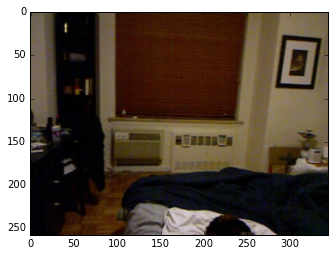

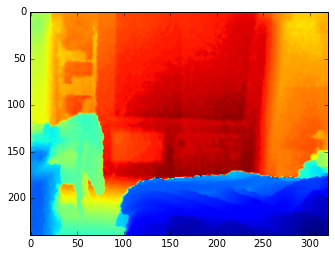

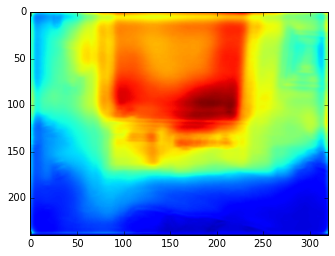

RMSE: 0.862303
LRMSE: 0.255523


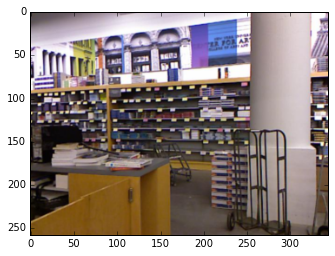

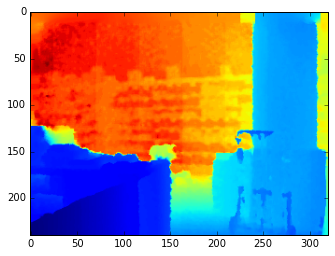

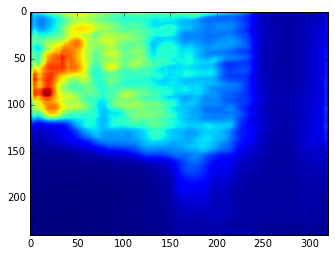

RMSE: 11.8274
LRMSE: 0.837671


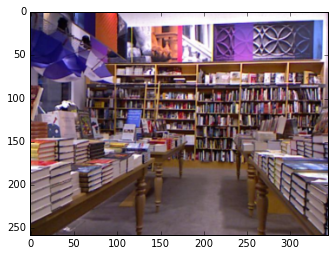

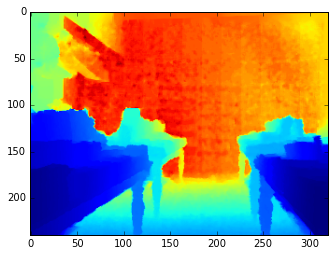

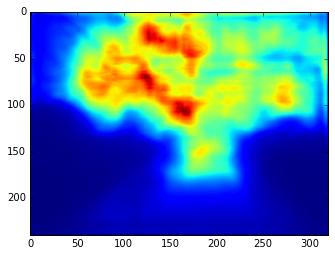

RMSE: 13.3139
LRMSE: 0.936419


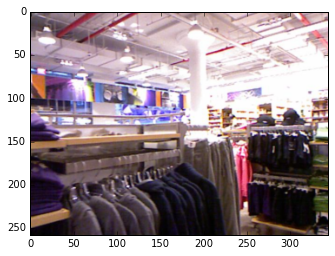

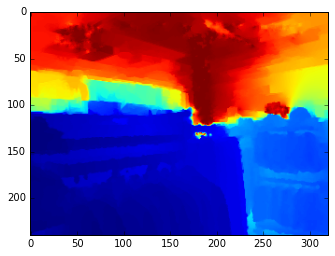

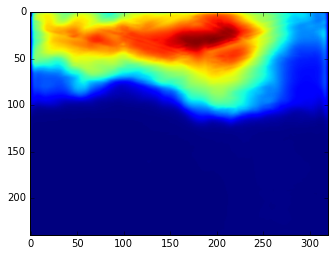

RMSE: 47.1869
LRMSE: 1.34842


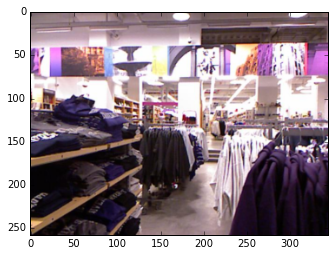

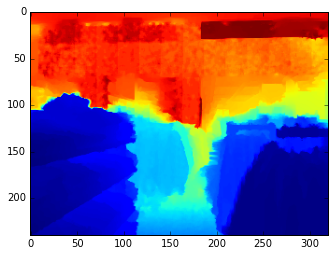

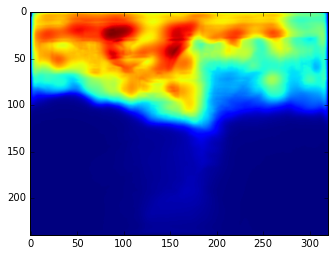

RMSE: 43.8078
LRMSE: 1.40447
Accumulated RMSE: 13.1514
Mean forward execution time (with Host -> GPU transfer): 0.085861


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout
import time

plot = True
idx = 0
diffs = []
timings = []
Dropout.set_dp_off()
for image in images:
    tmp = image.astype(np.float32).copy()
    # Stochastic normalization
    tmp -= mean
    tmp *= 1.0 / 72.240064849107824
    # center crop
    cy = (tmp.shape[1] - 240 ) // 2
    cx = (tmp.shape[2] - 320 ) // 2
    tmp = tmp[:,cy:cy+240,cx:cx+320]
    # Infer and measure time
    start = time.time()
    res = g.infer([tmp.reshape((1,3,240,320))])["conv_23_with_bias"]
    end = time.time()
    timings.append(end - start)
    res = res.squeeze()
    res = np.exp(res) / 1.6
    depth = depths[idx]
    tdepth = depth[cy:cy+240,cx:cx+320]

    if plot and idx % 20 == 0:
        
        plt.imshow(image.transpose((1,2,0)).astype(np.uint8))
        plt.show()
        plt.imshow(tdepth)
        plt.show()
        plt.imshow(res)
        plt.show()
        print "RMSE: " + str(np.sqrt(np.mean((res-tdepth)**2)))
        print "LRMSE: " + str(np.sqrt(np.mean((np.log(res) - np.log(tdepth))**2)))
        
    diffs.append(res - tdepth)
    
    idx += 1
    
diffs = np.array(diffs)
timings = np.array(timings)
rmse = np.sqrt(np.mean(diffs ** 2))
print "Accumulated RMSE: " + str(rmse)
print "Mean forward execution time (with Host -> GPU transfer): %f" % timings.mean()

# Infer random images from the internet

In [ ]:
import urllib, cStringIO
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout


Dropout.set_dp_off()


urls = [
    'http://www.hotel-im-wasserturm.de/fileadmin/_processed_/csm_Deluxe_Doppelzimmer_2_6455fa52be.jpg',
    'http://hotel-airport-zuerich.dorint.com/fileadmin/_processed_/csm_ZRH_Zimmer_DZ_04_bc3a12f87e.jpg',
    'http://www.erlebnis-erlensee.de/images/bilder/partyservice/schnitzel.jpg',
    'http://www.hankewitz.com/wp-content/uploads/2012/12/bolognese21.jpg'
       ]
for URL in urls:
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    img = Image.open(file)

    rs = img.resize((320,240))
    mean = np.load("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy")
    arr = np.array(rs).transpose((2,0,1)).astype(np.float32)
    arr -= mean
    arr *= 1.0 / 72.240064849107824
    res = g.infer([arr.reshape((1,3,240,320))])["conv_23_with_bias"]
    res = np.exp(res)
    # Montage to manipulate color scale
    mmax = 8.0
    # res[0,0,0,0] = 0.0
    # res[0,0,0,1] = mmax
    plt.imshow(rs)
    plt.show()
    plt.imshow(res.squeeze().clip(0.0,mmax))
    plt.show()

    print res.max()


# Infer image from food data


In [ ]:
import urllib, cStringIO
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout
import numpy as np

Dropout.set_dp_off()

data = np.load('/home/ga29mix/nashome/data/kinectv2_2016_03_30_13_33_25_bgr.npy')[:,:,0:3]
dd = np.load('/home/ga29mix/nashome/data/kinectv2_2016_03_30_13_33_25_depth.npy')

img = Image.fromarray(np.array(data[:,:,::-1]))
rs = img.resize((320,240))
mean = np.load("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy")
arr = np.array(rs).transpose((2,0,1)).astype(np.float32)
arr -= mean
arr *= 1.0 / 72.240064849107824
res = g.infer([arr.reshape((1,3,240,320))])["conv_23_with_bias"]
res = np.exp(res)
plt.imshow(img)
plt.show()
plt.imshow(res.squeeze())
plt.show()
plt.imshow(dd)
plt.show()
